In [1]:
import torch
import torch.nn as nn
from torch.functional import F
from sklearn import metrics
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
%matplotlib inline
import numpy as np
from utils import plot_confusion_matrix

In [2]:
x_train = torch.load("dataset/x_train")
y_train = torch.load("dataset/y_train")
x_test = torch.load("dataset/x_test")
y_test = torch.load("dataset/y_test")

In [3]:
class BiRNN(nn.Module):
    def __init__(self, embed_size, num_hiddens, num_layers, classes):
        super(BiRNN, self).__init__()
        # bidirectional设为True即得到双向循环神经网络

        self.encoder = nn.LSTM(input_size=embed_size,
                               hidden_size=num_hiddens,
                               num_layers=num_layers,
                               bidirectional=True)
        
        # 初始时间步和最终时间步的隐藏状态作为全连接层输入
        self.classifier = nn.Sequential(
            nn.Linear(4*num_hiddens, 128*num_hiddens),
            nn.BatchNorm1d(128*num_hiddens),
            nn.Sigmoid(),
            nn.Linear(128*num_hiddens,classes)
        )


    def forward(self, inputs):
        # inputs的形状是(批量大小, 词数, 词向量维度)，因为LSTM需要将序列长度(seq_len)作为第一维，所以将输入转置后
        # 再提取词特征，输出形状为(词数, 批量大小, 词向量维度)
        inputs = torch.transpose(inputs, 0, 1)
        # outputs形状是(词数, 批量大小, 2 * 隐藏单元个数)
        outputs, _ = self.encoder(inputs)  # output, (h, c)
        # 连结初始时间步和最终时间步的隐藏状态作为全连接层输入。它的形状为 (批量大小, 4 * 隐藏单元个数)。
        outs = torch.cat((outputs[0], outputs[-1]), -1)
        outs = self.classifier(outs)
        return outs

In [4]:
model = BiRNN(embed_size=100, num_hiddens=100, num_layers=5, classes=5)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [5]:
def batch_padding(batch_data):
    # 针对一批句子的长度（词向量个数）不一样时，全部补0到最大句子长度
    new_batch_data = []
    max_len = 0
    for s in batch_data:
        s = torch.tensor(s)
        new_batch_data.append(s)
        max_len = max(max_len,s.shape[0])
    for i in range(len(new_batch_data)):
        new_batch_data[i] = F.pad(new_batch_data[i], [0, 0, 0, max_len-new_batch_data[i].shape[0]])
    return torch.stack(new_batch_data, 0)	

In [6]:
sentences = batch_padding(x_train[0:5])
sentences.shape # [batch_size,句子中词的个数,词向量维度]

torch.Size([5, 4, 100])

In [7]:
print(model(sentences.to(device))) # 输出为OneHot编码形式

tensor([[-0.1220,  0.2974,  0.2398,  0.2664, -0.3694],
        [-0.1224,  0.2991,  0.2424,  0.2649, -0.3719],
        [-0.1221,  0.2985,  0.2415,  0.2655, -0.3703],
        [-0.1217,  0.2975,  0.2401,  0.2664, -0.3695],
        [-0.1220,  0.2983,  0.2428,  0.2651, -0.3711]], device='cuda:0',
       grad_fn=<AddmmBackward>)


## 训练

In [8]:
def train(model,dataset_x,dataset_y,num_epochs,
batch_size,optimizer,loss,batch_loss_list,batch_acc_list):
    model.train()
    for epoch in range(num_epochs):
        print("epoch",epoch)
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        batch_num = len(dataset_x) // batch_size
        for i in range(batch_num):
            X = batch_padding(dataset_x[i*batch_size : (i+1)*batch_size]).to(device)
            y = torch.tensor(dataset_y[i*batch_size : (i+1)*batch_size]).to(device)
            y_hat = model(X)
            y = y.argmax(dim=1).long()
            loss_ = loss(y_hat, y)
            optimizer.zero_grad()
            loss_.backward()
            optimizer.step()

            batch_loss = loss_.cpu().item()
            batch_acc = (y_hat.argmax(dim=1) == y).sum().cpu().item()
            batch_loss_list.append(batch_loss/batch_size)
            batch_acc_list.append(batch_acc/batch_size)
            print(f"epoch:{epoch},batch loss:{batch_loss/batch_size},batch acc:{batch_acc/batch_size}")
        

In [9]:
lr = 0.001
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad,model.parameters()), lr=lr)
loss = nn.CrossEntropyLoss().to(device) 

In [10]:
batch_loss_list = []
batch_acc_list = []

In [11]:
print("training... ")
train(model=model,dataset_x=x_train,dataset_y=y_train,
num_epochs=30,batch_size=256,optimizer=optimizer,loss=loss,
batch_loss_list=batch_loss_list,batch_acc_list=batch_acc_list)
# torch.save(model,"models/BiLSTM_v3.npy")

training... 
epoch 0
epoch:0,batch loss:0.006765749305486679,batch acc:0.1640625
epoch:0,batch loss:0.018402453511953354,batch acc:0.5546875
epoch:0,batch loss:0.02492784895002842,batch acc:0.51171875
epoch:0,batch loss:0.01746990531682968,batch acc:0.5703125
epoch:0,batch loss:0.011732346378266811,batch acc:0.4765625
epoch:0,batch loss:0.016174962744116783,batch acc:0.22265625
epoch:0,batch loss:0.018251435831189156,batch acc:0.14453125
epoch:0,batch loss:0.011813610792160034,batch acc:0.12109375
epoch 1
epoch:1,batch loss:0.008335170336067677,batch acc:0.5390625
epoch:1,batch loss:0.010333036072552204,batch acc:0.55859375
epoch:1,batch loss:0.010408180765807629,batch acc:0.515625
epoch:1,batch loss:0.008865263313055038,batch acc:0.5703125
epoch:1,batch loss:0.010446684435009956,batch acc:0.16015625
epoch:1,batch loss:0.009413281455636024,batch acc:0.1875
epoch:1,batch loss:0.009950639680027962,batch acc:0.04296875
epoch:1,batch loss:0.00816286075860262,batch acc:0.546875
epoch 2
epoc

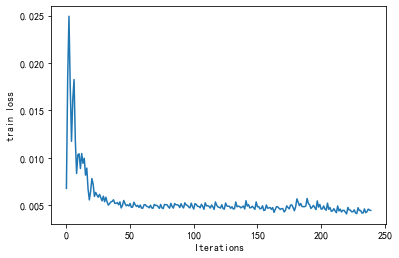

In [12]:
plt.xlabel('Iterations')
plt.ylabel('train loss')
plt.plot(np.arange(len(batch_loss_list)), batch_loss_list)

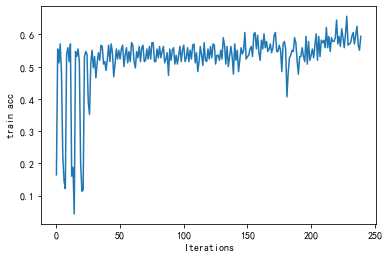

In [13]:
plt.xlabel('Iterations')
plt.ylabel('train acc')
plt.plot(np.arange(len(batch_acc_list)), batch_acc_list)

## 测试

In [14]:
def test(model,dataset_x,dataset_y,pred_list,real_list):
    model.eval()
    for i in range(len(dataset_x)):
        X = torch.tensor([dataset_x[i]]).to(device)
        y = torch.tensor([dataset_y[i]]).to(device)
        y_hat = model(X)
        pred_list.append(y_hat.argmax(dim=1).cpu().item())
        real_list.append(y.argmax(dim=1).cpu().item())

In [15]:
# model = torch.load("models/BiLSTM_v3.npy")
pred_list = []
real_list = []
print("testing... ")
test(model,x_test,y_test,pred_list,real_list)

testing... 


In [16]:
print(metrics.classification_report(real_list,pred_list))

              precision    recall  f1-score   support

           0       0.52      0.47      0.49       277
           1       0.26      0.64      0.37       109
           2       0.00      0.00      0.00        57
           3       0.00      0.00      0.00        16
           4       0.00      0.00      0.00        63

    accuracy                           0.38       522
   macro avg       0.16      0.22      0.17       522
weighted avg       0.33      0.38      0.34       522



e:\Software\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\Software\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\Software\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


显示百分比：
[[ 0.47  0.53  0.00  0.00  0.00]
 [ 0.34  0.64  0.00  0.00  0.02]
 [ 0.47  0.53  0.00  0.00  0.00]
 [ 0.31  0.69  0.00  0.00  0.00]
 [ 0.79  0.21  0.00  0.00  0.00]]


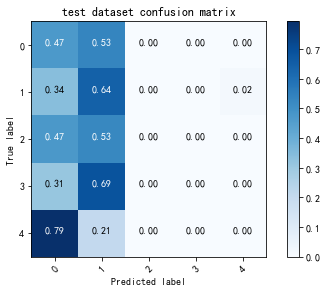

In [17]:
cm = metrics.confusion_matrix(real_list,pred_list)
plot_confusion_matrix(cm,range(5),normalize=True,title='test dataset confusion matrix')